# Electrode State of Health

This notebook demonstrates some utilities to work with electrode State of Health (also sometimes called electrode stoichiometry), using the algorithm from Mohtat et al [1]

[1] Mohtat, P., Lee, S., Siegel, J. B., & Stefanopoulou, A. G. (2019). Towards better estimability of electrode-specific state of health: Decoding the cell expansion. Journal of Power Sources, 427, 101-111.

In [1]:
%pip install pybamm -q # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Create and solve model

In [2]:
spm = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 2.8V",
    "Hold at 2.8V until C/50",
])
parameter_values = pybamm.ParameterValues("Mohtat2020")

sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()
spm_sol.plot([
    "Terminal voltage [V]", 
    "Current [A]", 
    "Negative electrode SOC",
    "Positive electrode SOC",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=2.3248583539193746, step=0.02324858353919374…

## Solve for electrode SOH variables

Given a total amount of lithium, $n_{Li}$, electrode capacities, $C_n$ and $C_p$, and voltage limits, $V_{min}$ and $V_{max}$, we can solve for the min and max electrode SOCs, $x_0$, $x_{100}$, $y_0$, and $y_{100}$,  and the cell capacity, $C$, using the algorithm adapted from Mohtat et al [1].
First, we find $x_{100}$ and $y_{100}$ using
$$
\begin{align}
C_{Li} &= y_{100}C_p + x_{100}C_n,
\\
V_{max} &= U_p(y_{100}) - U_n(x_{100}).
\end{align}
$$
Note that Mohtat et al use $n_{Li} = \frac{3600 C_{Li}}{F}$ instead.
Then, we find $C$ using
$$
\begin{align}
V_{min} &= U_p(y_{0}) - U_n(x_{0})
\\
&= U_p\left(y_{100} + \frac{C}{C_p}\right) - U_n\left(x_{100} - \frac{C}{C_n}\right)
\end{align}
$$
Finally, $x_0$ and $y_0$ are simply defined as
$$
\begin{align}
x_0 &= x_{100} - \frac{C}{C_n},
\\
y_0 &= y_{100} + \frac{C}{C_p}.
\end{align}
$$
We implement this in pybamm as an algebraic model.

In [3]:
param = pybamm.LithiumIonParameters()

Vmin = 2.8
Vmax = 4.2
Cn = parameter_values.evaluate(param.n.cap_init)
Cp = parameter_values.evaluate(param.p.cap_init)
C_Li = parameter_values.evaluate(param.C_Li_particles_init)

Un = param.n.prim.U_dimensional
Up = param.p.prim.U_dimensional
T_ref = param.T_ref

In [4]:
# First we solve for x_100 and y_100

model = pybamm.BaseModel()

x_100 = pybamm.Variable("x_100")
y_100 = (C_Li - x_100 * Cn) / Cp

y_100_min = 1e-10

x_100_upper_limit = (C_Li - y_100_min*Cp)/Cn

if not isinstance(x_100_upper_limit, float):
    x_100_upper_limit = x_100_upper_limit.value
    
x_100_upper_limit = min(x_100_upper_limit, 1-1e-10)


Vmax_init = parameter_values.evaluate(Up(y_100_min, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit, T_ref))
Vmin_init = parameter_values.evaluate(Up(y_100_min + 1, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit - Cp/Cn, T_ref))


if isinstance(parameter_values["Positive electrode OCP [V]"], tuple):
    # if data is provided for the Positive (or Negative) electrode OCP [V] 
    # the intial conditions must be within the bounds of this data to prevent extrapolation errors
    y_100_min = np.min(parameter_values["Positive electrode OCP [V]"][1][1])
    x_100_upper_limit = (C_Li - y_100_min * Cp) / Cn

    V_lower_bound = min(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()
    V_upper_bound = max(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()

    if Vmin_init[0][0] < V_lower_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))

    if Vmax_init[0][0] > V_upper_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))


model.algebraic = {
    x_100: Up(y_100, T_ref) - Un(x_100, T_ref) - Vmax + 1e5*(y_100<0) + 1e5*(x_100>1),
}
    
model.initial_conditions = {
    x_100: x_100_upper_limit
}

model.variables = {
    "x_100": x_100,
    "y_100": y_100
}


sim = pybamm.Simulation(model, parameter_values=parameter_values)

sol = sim.solve([0])

x_100 = sol["x_100"].data[0]
y_100 = sol["y_100"].data[0]

for var in ["x_100", "y_100"]:
    print(var, ":", sol[var].data[0])

# Based on the calculated values for x_100 and y_100 we solve for C
model = pybamm.BaseModel()

C = pybamm.Variable("C")
x_0 = x_100 - C/Cn
y_0 = y_100 + C/Cp

model.algebraic = {
    C: Up(y_0, T_ref) - Un(x_0, T_ref) - Vmin
}

model.initial_conditions = {C: pybamm.minimum(Cn * x_100 - 0.1, param.Q)}

model.variables = {
    "C": C,
    "x_0": x_0,
    "y_0": y_0,
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])


for var in ["C", "x_0", "y_0"]:
    print(var, ":", sol[var].data[0])

x_100 : 0.83337428922595
y_100 : 0.03354553395256055
C : 4.968932757076802
x_0 : 0.0015118456450778917
y_0 : 0.8908948800910447


This is implemented in PyBaMM as the `ElectrodeSOHSolver` class

In [5]:
esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)

inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "C_Li": C_Li}

esoh_sol = esoh_solver.solve(inputs)

for var in ["x_100", "y_100", "C", "x_0", "y_0"]:
    print(var, ":", esoh_sol[var].data[0])

x_100 : 0.8333742762029206
y_100 : 0.03354554737459437
C : 4.9689326792798925
x_0 : 0.0015118456462391093
y_0 : 0.8908948800898481


## Check against simulations

Plotting the SPM simulations against the eSOH calculations validates the min/max stoichiometry calculations

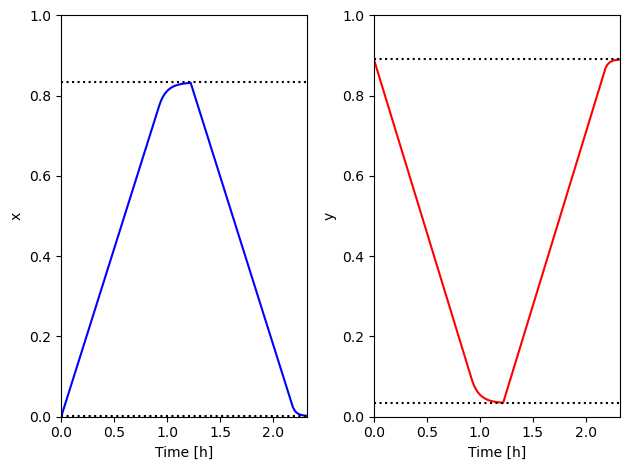

In [6]:
t = spm_sol["Time [h]"].data
x_spm = spm_sol["Negative electrode SOC"].data
y_spm = spm_sol["Positive electrode SOC"].data

x_0 = esoh_sol["x_0"].data * np.ones_like(t)
y_0 = esoh_sol["y_0"].data * np.ones_like(t)
x_100 = esoh_sol["x_100"].data * np.ones_like(t)
y_100 = esoh_sol["y_100"].data * np.ones_like(t)

fig, axes = plt.subplots(1,2)

axes[0].plot(t, x_spm, "b")
axes[0].plot(t, x_0, "k:")
axes[0].plot(t, x_100, "k:")
axes[0].set_ylabel("x")
    
axes[1].plot(t, y_spm, "r")
axes[1].plot(t, y_0, "k:")
axes[1].plot(t, y_100, "k:")
axes[1].set_ylabel("y")
    
for k in range(2):
    axes[k].set_xlim([t[0],t[-1]])
    axes[k].set_ylim([0,1])    
    axes[k].set_xlabel("Time [h]")
    
fig.tight_layout()


## How does electrode SOH depend on n_Li

In [11]:
all_parameter_sets = [
    k
    for k, v in pybamm.parameter_sets.items()
    if v["chemistry"] == "lithium_ion" and k not in ["Xu2019", "Chen2020_composite"]
]

def solve_esoh_sweep_nLi(parameter_set, param):
    parameter_values = pybamm.ParameterValues(parameter_set)
    esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)

    Vmin = parameter_values["Lower voltage cut-off [V]"]
    Vmax = parameter_values["Upper voltage cut-off [V]"]
    Cn = parameter_values.evaluate(param.n.cap_init)
    Cp = parameter_values.evaluate(param.p.cap_init)
    C_Li_init = parameter_values.evaluate(param.C_Li_particles_init)

    C_Li_sweep = np.linspace(1e-6, Cn + Cp)
    sweep = {}
    variables = ["C_Li", "x_0", "x_100", "y_0", "y_100", "C"]
    for var in variables:
        sweep[var] = []

    inputs = {"V_max": Vmax, "V_min": Vmin, "C_Li": C_Li_init, "C_n": Cn, "C_p": Cp}
    sol_init = esoh_solver.solve(inputs)

    print(parameter_set)
    print(f"C={sol_init['C'].data[0]:.3f}")
    print(f"Cn={Cn:.3f}")
    print(f"Cp={Cp:.3f}")
    print(f"C_Li_init={C_Li_init:.3f}")

    for C_Li in C_Li_sweep:
        inputs["C_Li"] = C_Li
        try:
            sol = esoh_solver.solve(inputs)
            for var in variables:
                sweep[var].append(sol[var].data[0])
        except (ValueError, pybamm.SolverError):
            pass

    return sweep, sol_init
    
for parameter_set in ["Chen2020"]:
    sweep, sol_init = solve_esoh_sweep_nLi(parameter_set, param)


Chen2020
C=5.153
Cn=5.828
Cp=8.732
C_Li_init=7.611
3.495111477092612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


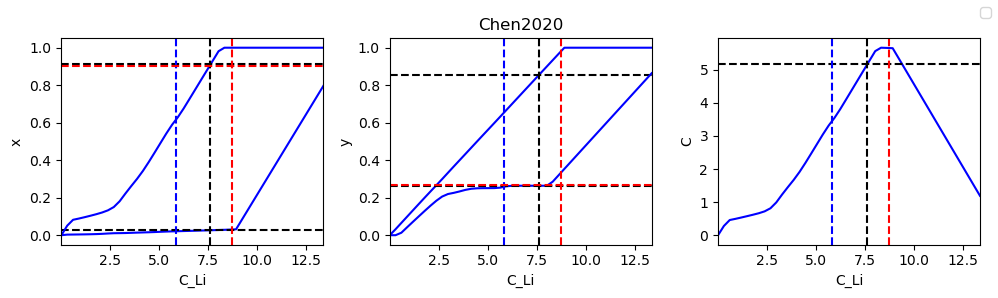

In [12]:

def plot_sweep(sweep, sol_init, parameter_set):
    fig, axes = plt.subplots(1,3,figsize=(10,3))
    parameter_values = pybamm.ParameterValues(parameter_set)
    Cn = parameter_values.evaluate(param.n.cap_init)
    Cp = parameter_values.evaluate(param.p.cap_init)
    # Plot min/max stoichimetric limits, including the value with the given C_Li
    for i,ks in enumerate([["x_0","x_100"],["y_0","y_100"],["C"]]):
        ax = axes.flat[i]
        for k in ks:
            ax.plot(sweep["C_Li"], sweep[k],"b-")
            ax.axhline(sol_init[k].data[0],c="k",linestyle="--")
        ax.set_xlabel("C_Li")
        ax.set_ylabel(ks[0][0])
        ax.set_xlim([np.min(sweep["C_Li"]),np.max(sweep["C_Li"])])
        ax.axvline(sol_init["C_Li"].data[0],c="k",linestyle="--")
        # Plot capacities of electrodes
        ax.axvline(Cn,c="b",linestyle="--")
        ax.axvline(Cp,c="r",linestyle="--")
    
    # Plot initial values of stoichometries
    sto_n_init = parameter_values.evaluate(param.n.prim.c_init_av)
    sto_p_init = parameter_values.evaluate(param.p.prim.c_init_av)
    axes[0].axhline(sto_n_init,c="r",linestyle="--")
    axes[1].axhline(sto_p_init,c="r",linestyle="--")

    axes[1].set_title(parameter_set)
    fig.legend()
    fig.tight_layout()
    return fig, axes

plot_sweep(sweep, sol_init, "Chen2020");

Ai2020
C=0.073
Cn=0.086
Cp=0.135
C_Li_init=0.131
0.0525897161179881


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Chen2020
C=5.153
Cn=5.828
Cp=8.732
C_Li_init=7.611
3.495111477092612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ecker2015
C=0.171
Cn=0.202
Cp=0.246
C_Li_init=0.230
0.11113378629280798


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Marquis2019
C=0.873
Cn=1.139
Cp=1.946
C_Li_init=2.079
0.7186668451186881
Mohtat2020
C=4.969
Cn=5.973
Cp=5.796
C_Li_init=5.172
2.941568835428466


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NCA_Kim2011
C=0.479
Cn=0.769
Cp=0.754
C_Li_init=0.793
0.3806410038821869


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OKane2022
C=5.110
Cn=5.828
Cp=8.732
C_Li_init=7.611
3.495111477092612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ORegan2022
C=5.049
Cn=5.203
Cp=7.163
C_Li_init=7.011
3.0139504651669773


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Prada2013
C=1.629
Cn=2.770
Cp=1.629
C_Li_init=2.413
1.0258259945767487


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ramadass2004
C=2.121
Cn=2.135
Cp=3.943
C_Li_init=3.551
1.3850265316591788


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


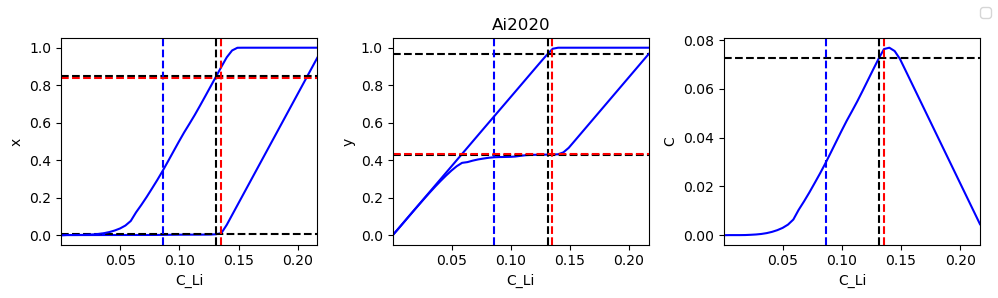

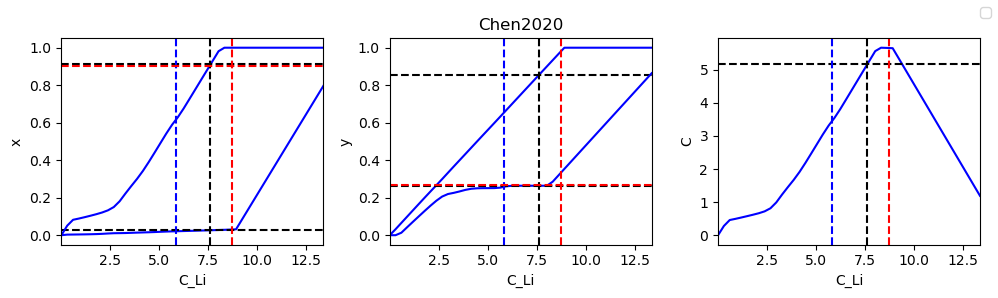

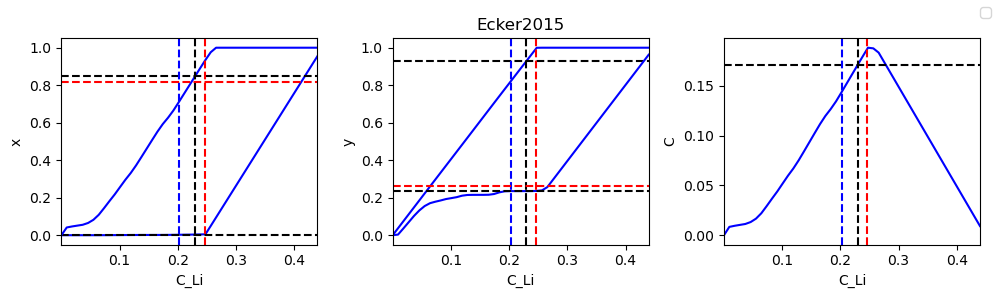

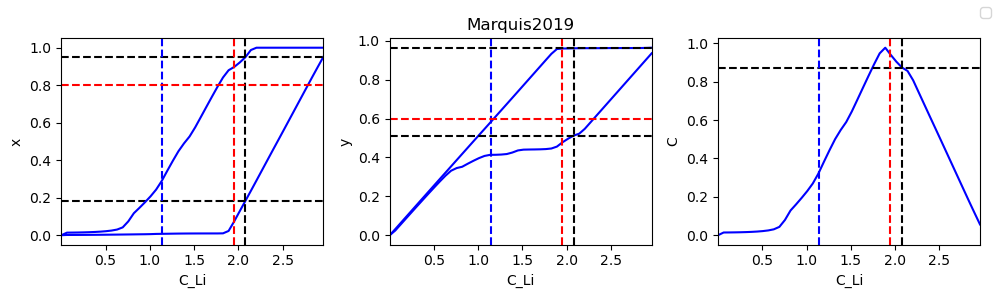

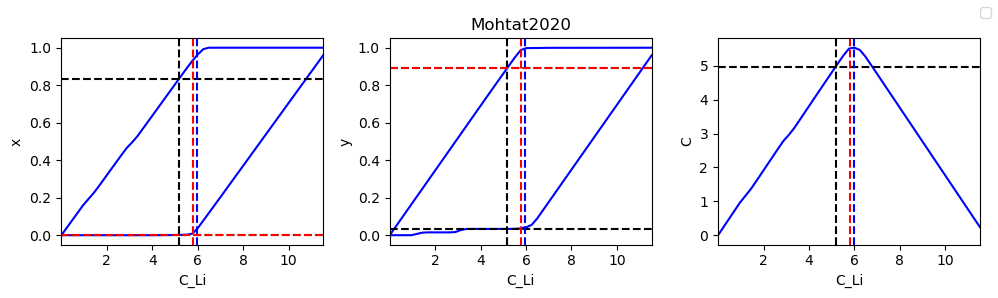

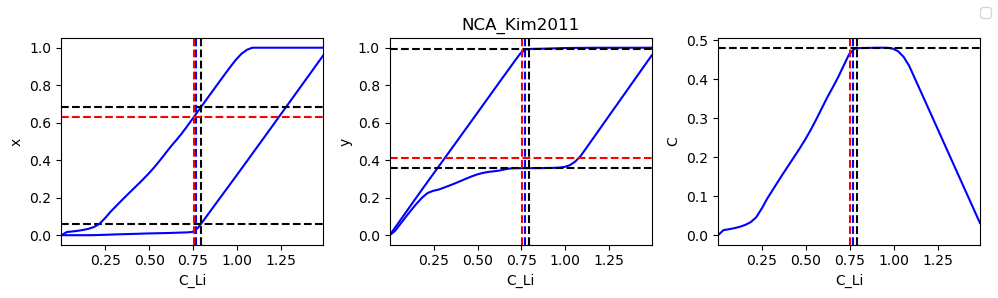

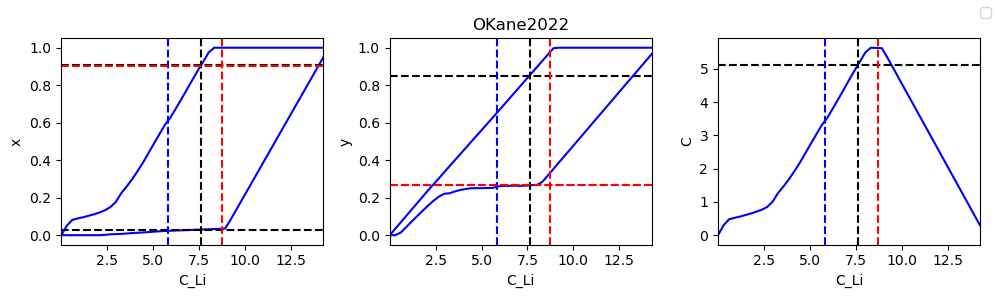

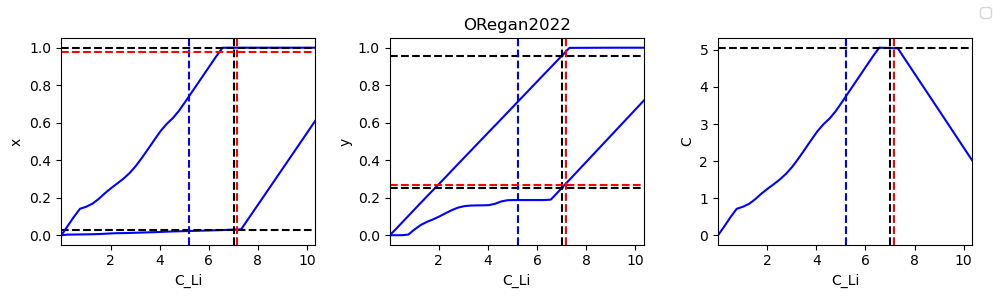

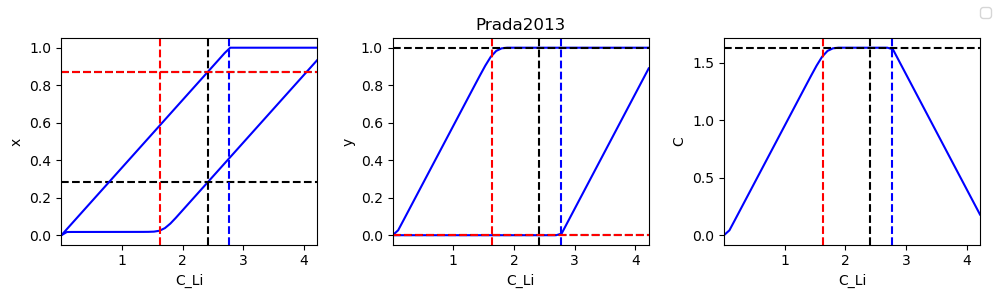

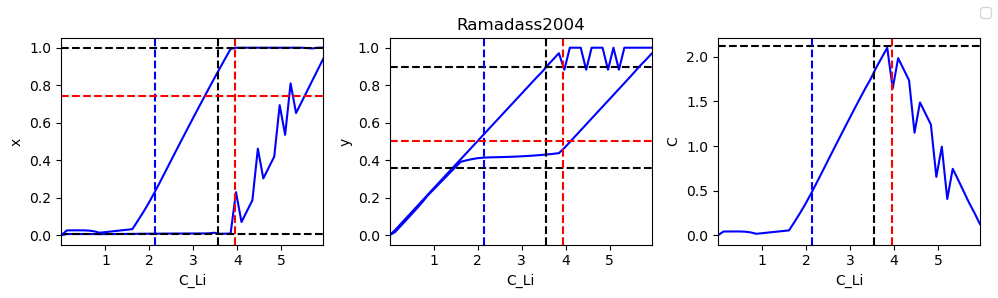

In [13]:
for parameter_set in all_parameter_sets:
    # print(parameter_set)
    fig, axes = plot_sweep(*solve_esoh_sweep_nLi(parameter_set, param), parameter_set)
    # print("success")


## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of